In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import sklearn 
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import os
import statsmodels.formula.api as smf
from sklearn.linear_model import OrthogonalMatchingPursuit

In [2]:
def split_variables(data):
    categorical_vars = []
    numerical_vars = []

    for column in data.columns:
        if "is_" in column:
            categorical_vars.append(column)
        else:
            numerical_vars.append(column)

    return categorical_vars, numerical_vars

def Vif_Examiner(data):
    issue = []
    for i in range(0,10):
        vif=variance_inflation_factor(data, i)
        if vif>=5:
            issue.append(i)
    return issue

def add_prefix_to_columns(df, prefix):
    new_columns = [df.columns[0]] + [prefix + col for col in df.columns[1:]]
    df.columns = new_columns
    return df

def check_skewness(data):
    
    skewness = np.mean((data - np.mean(data))**3) / np.power(np.var(data), 3/2)

    if skewness < -1:
        return -1 #left
    elif skewness > 1:
        return 1 #right
    else:
        return 0 #normal
    
def process_columns(df):
    # 获取从第四列开始的所有列
    columns_to_process = df.columns[3:]
    right_skewed = []
    left_skewed = []
    # check skewness
    for column in columns_to_process:
        result = check_skewness(df[column])
        if result == 1:
            right_skewed.append(column)
            continue
        if result == -1:
            left_skewed.append(column)
    return right_skewed,left_skewed

def forward_select(data,target):
###向前遍历，找到可以降下AIC的就选上，缺点是删不掉
    variate=set(data.columns)  #将字段名转换成字典类型
    variate.remove(target)  #去掉因变量的字段名
    selected=[]
    n=data.shape[0]
    current_score,best_new_score=float('inf'),float('inf')  #目前的分数和最好分数初始值都为无穷大（因为AIC越小越好）
    #循环筛选变量
    while variate:
        aic_with_variate=[]
        for candidate in variate:  #逐个遍历自变量
            formula="{}~{}".format(target,"+".join(selected+[candidate]))  #将自变量名连接起来
            K = formula.count('+')+1
            aic=smf.ols(formula=formula,data=data).fit().aic+ 2*K*(K+1)/(n-K-1)  #利用ols训练模型得出aic值
            aic_with_variate.append((aic,candidate))  #将第每一次的aic值放进空列表
        aic_with_variate.sort(reverse=True)  #降序排序aic值
        best_new_score,best_candidate=aic_with_variate.pop()  #最好的aic值等于删除列表的最后一个值，以及最好的自变量等于列表最后一个自变量
        if current_score>best_new_score:  #如果目前的aic值大于最好的aic值
            variate.remove(best_candidate)  #移除加进来的变量名，即第二次循环时，不考虑此自变量了
            selected.append(best_candidate)  #将此自变量作为加进模型中的自变量
            current_score=best_new_score  #最新的分数等于最好的分数
            print("aic is {},continuing!".format(current_score))  #输出最小的aic值
        else:
            print("forward selection over!")
            break
    formula="{}~{}".format(target,"+".join(selected))  #最终的模型式子
    print("final formula is {}".format(formula))
    model=smf.ols(formula=formula,data=data).fit()
    return model,selected


def stepwise_selection(data, target):
    variate = set(data.columns)
    variate.remove(target)
    selected = []
    n = data.shape[0]
    current_score, best_new_score = float('inf'), float('inf')

    while variate or selected:
        forward_candidate, backward_candidate = None, None
        best_backward_score = float('inf')
        # Forward step
        if variate:
            forward_aic_with_variate = []
            for candidate in variate:
                formula = "{}~{}".format(target, "+".join(selected + [candidate]))
                K = formula.count('+')+1
                if n/K < 40:
                    aic = smf.ols(formula=formula, data=data).fit().aic+ 2*K*(K+1)/(n-K-1)
                else:
                    aic = smf.ols(formula=formula, data=data).fit().aic
                forward_aic_with_variate.append((aic, candidate))
            forward_aic_with_variate.sort(reverse=True)
            best_forward_score, forward_candidate = forward_aic_with_variate.pop()
        # Backward step
        if len(selected) > 1:
            backward_aic_with_variate = []
            for candidate in selected:
                selected_new = selected.copy()
                selected_new.remove(candidate)
                formula = "{}~{}".format(target, "+".join(selected_new))
                K = formula.count('+')+1
                if n/K < 40:
                    aic = smf.ols(formula=formula, data=data).fit().aic+ 2*K*(K+1)/(n-K-1)
                else:
                    aic = smf.ols(formula=formula, data=data).fit().aic
                backward_aic_with_variate.append((aic, candidate))
            backward_aic_with_variate.sort(reverse=True)
            best_backward_score, backward_candidate = backward_aic_with_variate.pop()

        # Compare
        if (forward_candidate is not None and best_forward_score < current_score) or \
           (backward_candidate is not None and best_backward_score < current_score):
            if best_forward_score <= best_backward_score:
                variate.remove(forward_candidate)
                selected.append(forward_candidate)
                current_score = best_forward_score
                print('continue,best aic is{}',current_score)
            else:
                selected.remove(backward_candidate)
                current_score = best_backward_score
                print('continue,best aic is{}',current_score)
        else:
            break

    formula = "{}~{}".format(target, "+".join(selected))
    model = smf.ols(formula=formula, data=data).fit()

    return model,selected



In [25]:
path = './data/brain/Train/'
fulldata = pd.read_csv(os.path.join(path,'subject_info - 1600.csv')).iloc[:,:-1]
for file in os.listdir(path):
    if 'subject_info' in file:
        continue
    temp = add_prefix_to_columns(pd.read_csv(os.path.join(path,file)),file.split('-')[0])
    fulldata = pd.merge(fulldata, temp, on='subject_ID', how='inner')
fulldata.drop(['MRI扫描仪类型','subject_ID'],axis=1,inplace=True)
fulldata.rename(columns={'性别': 'sex', '年龄': 'age'}, inplace=True)
fulldata.columns = fulldata.columns.str.replace(' ', '')
fulldata.columns = fulldata.columns.str.replace('.', '')
fulldata.columns = fulldata.columns.str.replace('-', '')
fulldata['sex'] = fulldata['sex'].replace(2,0)
fulldata

C:\Users\moonk\AppData\Local\Temp\ipykernel_4248\2018903828.py:11: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  fulldata.columns = fulldata.columns.str.replace('.', '')


,sex,age,asegLeftCerebellumWhiteMatter,asegLeftCerebellumCortex,asegLeftThalamus,asegLeftCaudate,asegLeftPutamen,asegLeftPallidum,asegBrainStem,asegLeftHippocampus,...,wmparcwmrhsuperiorfrontal,wmparcwmrhsuperiorparietal,wmparcwmrhsuperiortemporal,wmparcwmrhsupramarginal,wmparcwmrhfrontalpole,wmparcwmrhtemporalpole,wmparcwmrhtransversetemporal,wmparcwmrhinsula,wmparcLeftUnsegmentedWhiteMatter,wmparcRightUnsegmentedWhiteMatter
0,0,25,13706.1,50274.2,7559.5,3314.4,4922.1,1671.2,17953.4,4179.7,...,18565.4,11848.3,8129.0,8736.6,381.7,723.3,636.2,10862.9,34016.5,32253.2
1,1,26,11981.9,51047.5,8563.6,3525.5,5072.9,1633.4,17662.2,4247.6,...,15577.1,10289.2,6145.2,8386.2,307.4,715.4,496.3,8409.0,30334.0,33284.7
2,0,27,21259.1,62010.0,9594.8,3376.6,5125.7,2386.0,22903.6,4604.2,...,22376.1,11366.6,8323.6,9290.7,484.2,734.7,613.3,10585.0,34007.3,32710.9
3,0,32,21745.4,54823.7,8708.1,4503.2,6281.9,2259.7,22801.7,4925.7,...,18305.7,12225.8,9422.6,9690.4,452.8,844.0,654.0,11146.3,31778.2,30407.8
4,0,32,17233.3,57743.1,9288.5,3706.9,5902.9,2511.3,21597.8,4795.1,...,17272.5,12557.2,7031.8,8993.7,395.9,1033.6,600.9,10615.9,34509.2,32888.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1591,1,26,13786.4,54537.3,7902.8,3075.6,4129.8,1991.4,20980.4,4229.0,...,16386.7,14765.0,7485.8,9449.4,345.1,930.7,861.4,9895.0,35185.6,35635.4
1592,1,39,14876.8,55987.1,8009.5,3343.2,5091.7,1974.9,21835.5,3630.9,...,17264.9,12851.4,6271.0,8483.7,347.3,642.3,779.0,9703.9,35090.9,34014.9
1593,1,36,15533.6,52459.5,8732.0,3410.0,5185.2,2125.4,21134.2,4051.4,...,18231.9,13271.8,6718.9,6707.7,406.5,857.8,676.4,9093.7,29642.8,30435.8
1594,0,21,22349.1,56921.2,10410.8,4130.0,5464.3,2476.4,22135.7,4073.4,...,21797.0,12247.4,8580.3,9761.5,470.4,763.9,666.0,9403.8,34844.6,35012.3


In [24]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf

# Assuming that you have your dataset loaded into a DataFrame called 'fulldata'

# Adding a new column for age with the transformed values (age^0.75)
fulldata['age_transformed'] = fulldata['age'] ** 0.75

# Defining the formula for linear regression with interaction terms
formula = "age_transformed ~ wmparcwmlhmedialorbitofrontal + wmparcwmlhinsula + sex + rhGrayVolsuperiorfrontal + asegLeftThalamus + asegLeftPutamen + asegBrainStem + asegRightCerebellumCortex + asegOpticChiasm + lhThickAvglateraloccipital + lhMeanCurvprecentral + asegBrainStem:asegOpticChiasm + rhGrayVolsuperiorfrontal:asegLeftPutamen + wmparcwmlhinsula:rhGrayVolsuperiorfrontal"

# Performing the linear regression
base_model_interact = smf.ols(formula, data=fulldata).fit()

# Displaying the summary of the regression results
print(base_model_interact.summary())


                            OLS Regression Results                            
Dep. Variable:        age_transformed   R-squared:                       0.558
Model:                            OLS   Adj. R-squared:                  0.555
Method:                 Least Squares   F-statistic:                     142.9
Date:                Sat, 22 Jul 2023   Prob (F-statistic):          2.23e-268
Time:                        23:17:15   Log-Likelihood:                -3829.7
No. Observations:                1596   AIC:                             7689.
Df Residuals:                    1581   BIC:                             7770.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------

Pearson Correlation Coefficient: 0.7476260751015358
P-Value: 1.2236243598752987e-285


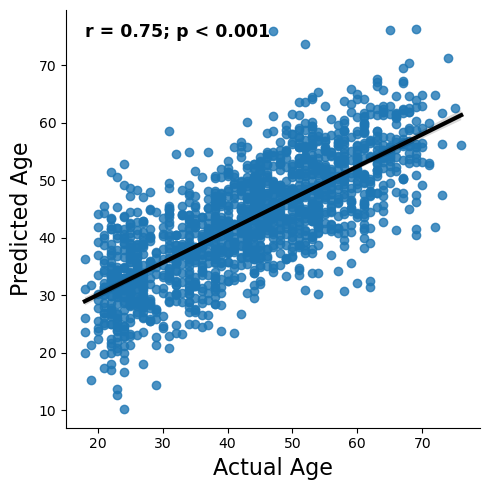

In [39]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import seaborn as sns
import os
from scipy.stats import pearsonr

# Assuming you have already defined 'fulldata' using the provided code

# Adding a new column for age with the transformed values (age^0.75)
fulldata['age_transformed'] = fulldata['age'] ** 0.75

# Convert 'age' column to numeric data type
fulldata['age'] = pd.to_numeric(fulldata['age'])

# Defining the formula for linear regression with interaction terms
formula = "age_transformed ~ wmparcwmlhmedialorbitofrontal + wmparcwmlhinsula + sex + rhGrayVolsuperiorfrontal + asegLeftThalamus + asegLeftPutamen + asegBrainStem + asegRightCerebellumCortex + asegOpticChiasm + lhThickAvglateraloccipital + lhMeanCurvprecentral + asegBrainStem:asegOpticChiasm + rhGrayVolsuperiorfrontal:asegLeftPutamen + wmparcwmlhinsula:rhGrayVolsuperiorfrontal"

# Performing the linear regression
base_model_interact = smf.ols(formula, data=fulldata).fit()

# Extracting actual and predicted age values
actual_age = fulldata['age']
fulldata['predicted_age'] = base_model_interact.predict(fulldata) ** (4/3)

# Pearson correlation test
correlation_coefficient, p_value = pearsonr(actual_age, fulldata['predicted_age'])

# Print the correlation coefficients with its corresponding p-value
print("Pearson Correlation Coefficient:", correlation_coefficient)
print("P-Value:", p_value)

# Set fontsize for axis labels
plt.rc('axes', labelsize=16)

# Creating the scatter plot with the regression line using seaborn's lmplot
sns.lmplot(x='age', y='predicted_age', data=fulldata, line_kws={'color': 'black', 'linewidth':3})
plt.xlabel('Actual Age')
plt.ylabel('Predicted Age')
# plt.title('Predicted Age vs. Actual Age')

# Adding text at the upper left corner
plt.text(18, 75, 'r = 0.75; p < 0.001', color='black', fontsize=12.5, fontweight='bold')

plt.show()

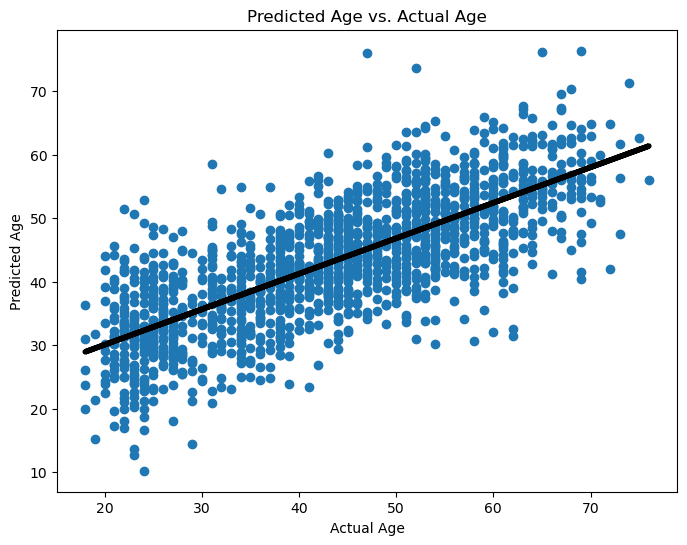

In [22]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import os

# Assuming you have already defined 'fulldata' using the provided code

# Adding a new column for age with the transformed values (age^0.75)
fulldata['age_transformed'] = fulldata['age'] ** 0.75

# Defining the formula for linear regression with interaction terms
formula = "age_transformed ~ wmparcwmlhmedialorbitofrontal + wmparcwmlhinsula + sex + rhGrayVolsuperiorfrontal + asegLeftThalamus + asegLeftPutamen + asegBrainStem + asegRightCerebellumCortex + asegOpticChiasm + lhThickAvglateraloccipital + lhMeanCurvprecentral + asegBrainStem:asegOpticChiasm + rhGrayVolsuperiorfrontal:asegLeftPutamen + wmparcwmlhinsula:rhGrayVolsuperiorfrontal"

# Performing the linear regression
base_model_interact = smf.ols(formula, data=fulldata).fit()

# Extracting actual and predicted age values
actual_age = fulldata['age']
predicted_age = base_model_interact.predict(fulldata) ** (4/3)

# Creating the scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(actual_age, predicted_age)
plt.xlabel('Actual Age')
plt.ylabel('Predicted Age')
plt.title('Predicted Age vs. Actual Age')

# Adding linear regression line
regression_line = np.polyfit(actual_age, predicted_age, 1)
plt.plot(actual_age, np.polyval(regression_line, actual_age), color='k', linewidth=4)

plt.grid(False)
plt.show()


In [23]:
filter_ed = fulldata[['age'] + [col for col in fulldata.columns if ('lh' not in col) ]]
filter_ed 

,age,sex,age,wmparcwmrhbankssts,wmparcwmrhcaudalanteriorcingulate,wmparcwmrhcaudalmiddlefrontal,wmparcwmrhcuneus,wmparcwmrhentorhinal,wmparcwmrhfusiform,wmparcwmrhinferiorparietal,...,rhGausCurvprecentral,rhGausCurvprecuneus,rhGausCurvrostralanteriorcingulate,rhGausCurvrostralmiddlefrontal,rhGausCurvsuperiorfrontal,rhGausCurvsuperiorparietal,rhGausCurvsuperiortemporal,rhGausCurvsupramarginal,rhGausCurvtransversetemporal,rhGausCurvinsula
0,25,0,25,2641.2,2627.1,6636.0,3224.6,807.7,5982.0,10893.7,...,4870,3895,792,3429,8169,4072,4966,3453,356,1987
1,26,1,26,1534.0,2193.7,4104.5,3141.9,575.7,6473.1,9344.5,...,4120,4187,627,3026,7022,3727,3905,3119,326,1830
2,27,0,27,2684.2,2893.4,7090.0,3200.0,1095.5,6210.2,13254.2,...,5537,3892,979,4332,10448,4437,5390,3874,403,2380
3,32,0,32,2866.7,2558.5,5379.3,3113.0,1130.6,7211.6,13000.0,...,5852,4924,818,4421,9437,4259,5906,3980,400,2368
4,32,0,32,2797.5,2364.9,5715.7,3577.5,1034.9,6507.7,12974.3,...,4570,4198,779,3322,8125,4571,4657,3690,363,2287
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1591,26,1,26,2887.5,2802.4,5767.1,3443.4,967.5,7006.9,13019.1,...,4617,4758,774,3518,8101,5367,4722,3697,320,1998
1592,39,1,39,3101.8,3204.0,7045.5,2468.9,438.9,5663.2,9906.8,...,4584,4136,809,3851,7651,4466,4395,3066,318,1909
1593,36,1,36,2849.6,2837.2,7831.0,2915.8,543.1,6800.1,14278.5,...,4688,4321,841,3850,8448,4472,4837,3077,369,2048
1594,21,0,21,3463.8,3527.2,7240.2,3555.4,937.1,6839.6,11634.9,...,6218,4632,908,5596,11140,4896,5738,4054,373,2193


In [22]:
target = fulldata['age']
#features = fulldata.drop('age', axis=1)
features = filter_ed.drop('age', axis=1)
# 创建 OMP 对象
omp = OrthogonalMatchingPursuit(n_nonzero_coefs=20)

# 使用 OMP 进行变量筛选
omp.fit(features, target)

# Get the estimated coefficients
coefficients = omp.coef_

# Get the indices of non-zero coefficients
selected_indices = (coefficients != 0)

# Get the names of selected features
selected_features = features.columns[selected_indices]

print("Selected features length :", len(selected_features))
selected_features
# sub_df = sub_df[selected_features]
# sub_df

Selected features length : 1


/home/weilinda/miniconda3/envs/ofa/lib/python3.7/site-packages/sklearn/linear_model/_base.py:138: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), OrthogonalMatchingPursuit())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  FutureWarning,
/home/weilinda/miniconda3/envs/ofa/lib/python3.7/site-packages/sklearn/linear_model/_omp.py:766: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  return_n_iter=True,


Index(['age'], dtype='object')

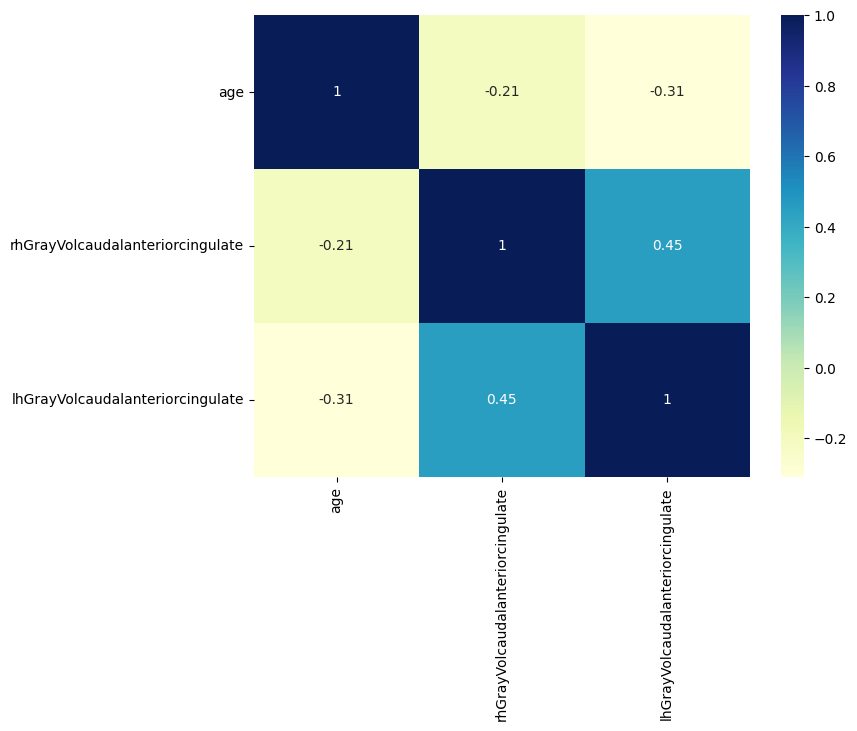

In [53]:
plt.figure(figsize=(8, 6))
sns.heatmap(round(sub_df.corr(),2),annot=True, cmap='YlGnBu')
plt.show()

In [16]:
model_try,selected_feature = forward_select(fulldata,'age')

aic is 12506.11097862148,continuing!
aic is 12402.409717084753,continuing!
aic is 12257.412140983395,continuing!
aic is 12181.402518154877,continuing!
aic is 11990.971196012717,continuing!
aic is 11894.383085972073,continuing!


KeyboardInterrupt: 

In [4]:
fulldata['age'].value

<bound method IndexOpsMixin.value_counts of 0       25
1       26
2       27
3       32
4       32
        ..
1591    26
1592    39
1593    36
1594    21
1595    38
Name: age, Length: 1596, dtype: int64>

In [14]:
# 将第一列设置为响应变量
response = fulldata.iloc[:, 1]
# 将剩余所有列设置为预测变量（自变量）
predictors = sub_df

# 添加截距列
predictors = sm.add_constant(predictors)

# 构建线性回归模型
model = sm.OLS(response, predictors)

# 拟合模型
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    age   R-squared:                       0.611
Model:                            OLS   Adj. R-squared:                  0.606
Method:                 Least Squares   F-statistic:                     123.7
Date:                Thu, 13 Jul 2023   Prob (F-statistic):          3.98e-305
Time:                        20:08:55   Log-Likelihood:                -5674.6
No. Observations:                1596   AIC:                         1.139e+04
Df Residuals:                    1575   BIC:                         1.150e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const                                53.9385      5.681      9.495      0.000      42.796      65.082
sex                                  -3.6055      0.522     -6.912      0.000      -4.629      -2.582
wmparcwmlhisthmuscingulate            0.0021      0.000      4.481      0.000       0.001       0.003
wmparcwmlhmedialorbitofrontal         0.0025      0.000      5.841      0.000       0.002       0.003
wmparcwmlhinsula                      0.0025      0.000      9.662      0.000       0.002       0.003
rhGrayVolparsopercularis             -0.0020      0.000     -6.408      0.000      -0.003      -0.001
rhGrayVolrostralanteriorcingulate    -0.0020      0.000     -5.641      0.000      -0.003      -0.001
rhGrayVolsuperiorfrontal             -0.0007   9.19e-05     -7.909      0.000      -0.001      -0.001
asegLeftThalamus                     -0.0062      0.000    -19.267      0.000      -0.007      -0.006
asegLeftPutamen                      -0.0027      0.000     -6.929      0.000      -0.004      -0.002
asegBrainStem                         0.0022      0.000     14.488      0.000       0.002       0.003
asegLeftAccumbensarea                -0.0125      0.002     -5.310      0.000      -0.017      -0.008
asegRightCerebellumCortex            -0.0007   4.91e-05    -14.355      0.000      -0.001      -0.001
asegOpticChiasm                       0.0362      0.005      6.701      0.000       0.026       0.047
asegCC_Posterior                      0.0065      0.002      4.205      0.000       0.003       0.010
asegCC_Mid_Anterior                  -0.0111      0.001     -8.038      0.000      -0.014      -0.008
rhThickAvgmedialorbitofrontal       -10.7498      1.577     -6.818      0.000     -13.842      -7.657
rhThickAvgpostcentral                10.3929      1.956      5.313      0.000       6.556      14.230
lhThickAvglateraloccipital           11.8024      1.881      6.274      0.000       8.112      15.492
lhMeanCurvparahippocampal           -71.4930     16.157     -4.425      0.000    -103.184     -39.802
lhMeanCurvprecentral                178.1383     16.311     10.921      0.000     146.144     210.132
==============================================================================
Omnibus:                        2.612   Durbin-Watson:                   1.596
Prob(Omnibus):                  0.271   Jarque-Bera (JB):                2.774
Skew:                          -0.000   Prob(JB):                        0.250
Kurtosis:                       3.204   Cond. No.                     5.48e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.48e+06. This might indic

In [8]:
right_skewed,left_skewed = process_columns(fulldata)
right_skewed


['wmparc wm-lh-parahippocampal',
 'wmparc wm-lh-parsorbitalis',
 'wmparc wm-lh-posteriorcingulate',
 'wmparc wm-lh-rostralanteriorcingulate',
 'wmparc wm-lh-frontalpole',
 'wmparc wm-lh-transversetemporal',
 'wmparc wm-rh-entorhinal',
 'wmparc wm-rh-isthmuscingulate',
 'wmparc wm-rh-parahippocampal',
 'wmparc wm-rh-parsorbitalis',
 'wmparc wm-rh-posteriorcingulate',
 'wmparc wm-rh-rostralanteriorcingulate',
 'wmparc wm-rh-frontalpole',
 'wmparc wm-rh-temporalpole',
 'wmparc wm-rh-transversetemporal',
 'wmparc wm-rh-insula',
 'wmparc Left-UnsegmentedWhiteMatter',
 'wmparc Right-UnsegmentedWhiteMatter',
 'rh.GrayVolrostralanteriorcingulate',
 'lh.SurfArea parahippocampal',
 'lh.SurfArea transversetemporal',
 'aseg Left-Cerebellum-White-Matter',
 'aseg CC_Mid_Posterior',
 'rh.SurfArea entorhinal',
 'rh.SurfArea isthmuscingulate',
 'rh.SurfArea medialorbitofrontal',
 'rh.SurfArea rostralanteriorcingulate',
 'rh.MeanCurvcaudalanteriorcingulate',
 'rh.MeanCurvfusiform',
 'rh.MeanCurvinferior

<AxesSubplot:xlabel='rh.GausCurventorhinal', ylabel='Count'>

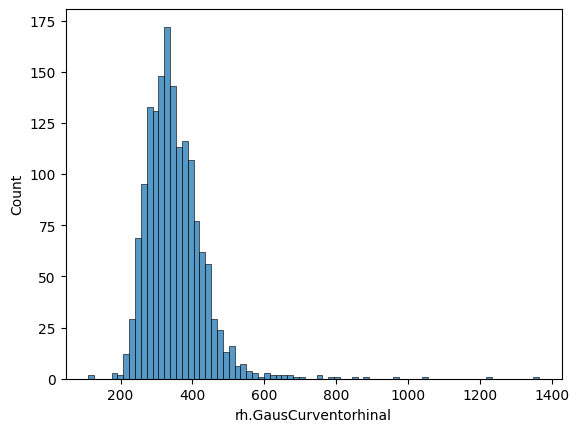

In [9]:
sns.histplot(data=fulldata,x='rh.GausCurventorhinal')